<a href="https://colab.research.google.com/github/debashisdotchatterjee/Harmonizing-Epidemiological-Time-CDC-ISO/blob/main/Harmonizing_Epidemiological_Time_CDC_ISO_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

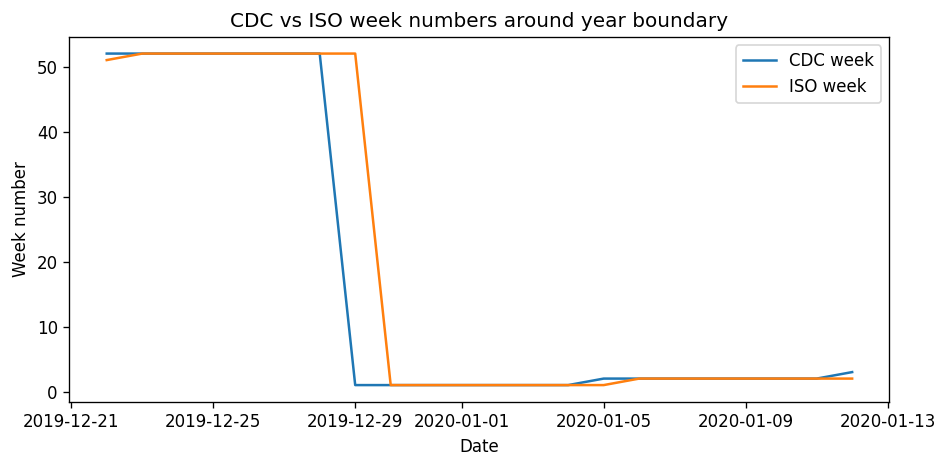

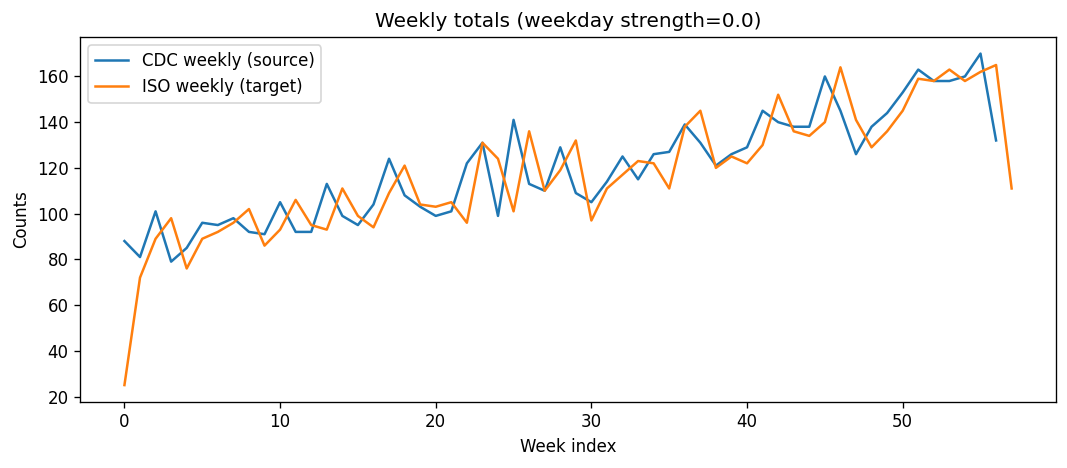

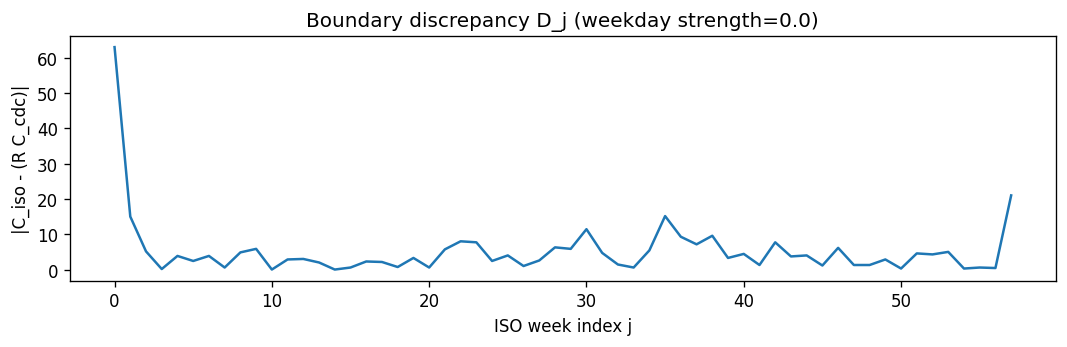

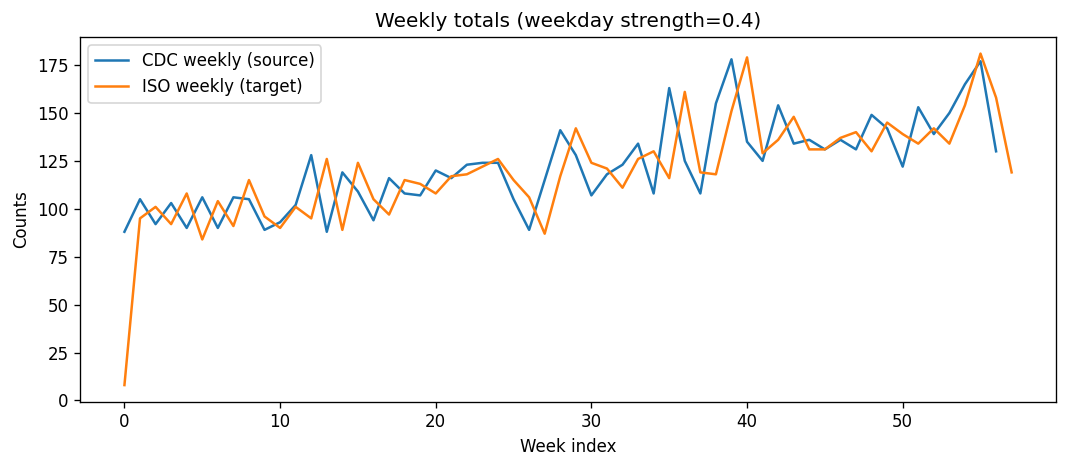

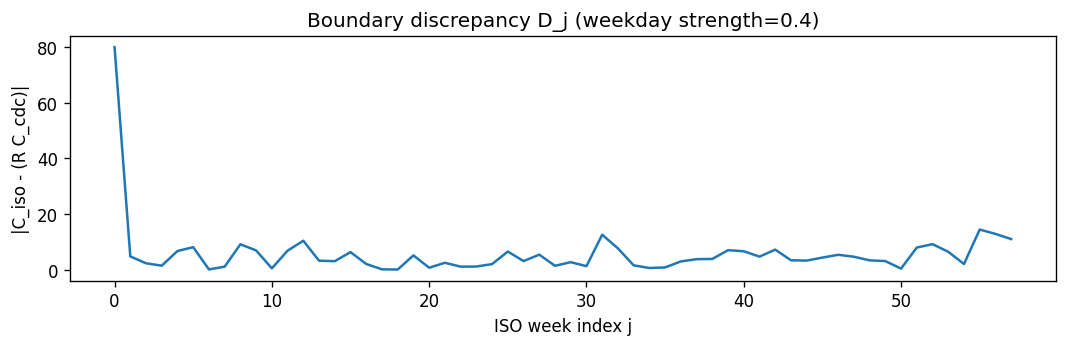

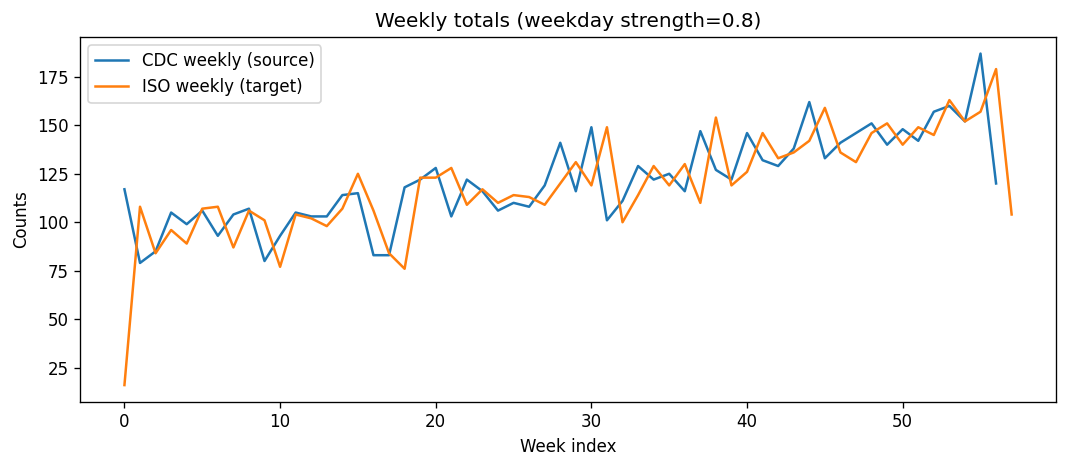

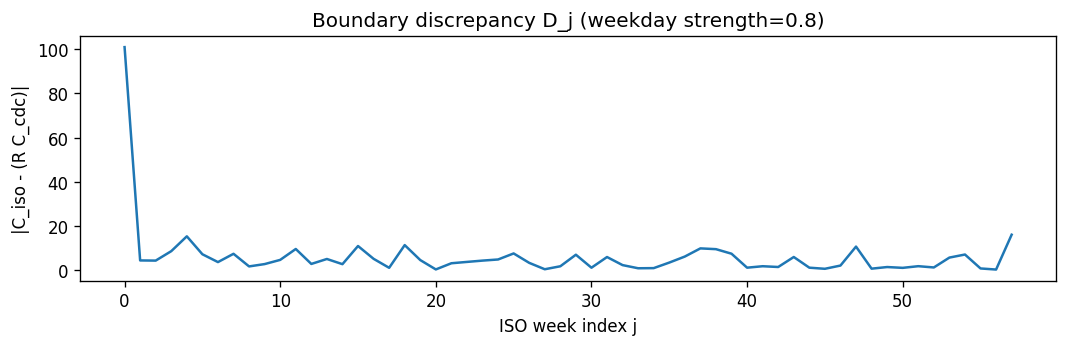


=== Simulation Summary (by weekday_strength) ===
 weekday_strength  reps  bias_naive_mean  bias_corr_mean  mae_naive  mae_corr  cover_naive  cover_corr  se_naive_mean  se_corr_mean
              0.0    30         1.250566        0.000714   1.250566  0.000898          0.0    0.800000   6.265575e-12      0.000729
              0.4    30         1.232031        0.000569   1.232031  0.000709          0.0    0.900000   7.328264e-12      0.000730
              0.8    30         1.259660        0.000777   1.259660  0.000791          0.0    0.833333   2.655599e-12      0.000729


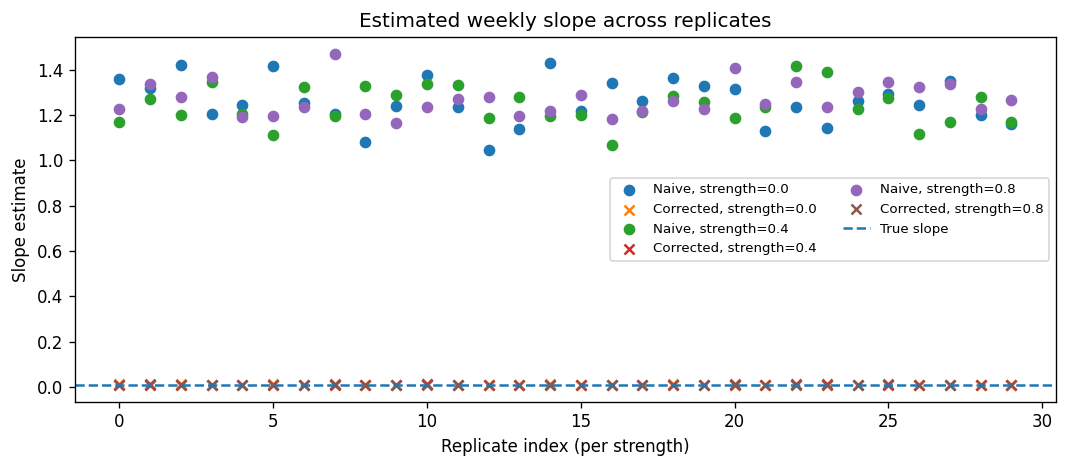


=== Head of Raw Results ===
 weekday_strength  rep  beta1_true  beta1_naive  beta1_corr  bias_naive  bias_corr     se_naive  se_corr  cover_naive  cover_corr  iters_naive  iters_corr
              0.0    0        0.01     1.359839    0.011645    1.349839   0.001645 7.309031e-13 0.000733            0           0          100         155
              0.0    1        0.01     1.319696    0.011066    1.309696   0.001066 3.880292e-13 0.000725            0           1          100         156
              0.0    2        0.01     1.420714    0.011910    1.410714   0.001910 9.345971e-14 0.000725            0           0          100         159
              0.0    3        0.01     1.202898    0.010286    1.192898   0.000286 6.188641e-12 0.000731            0           1          100         150
              0.0    4        0.01     1.242087    0.010623    1.232087   0.000623 3.574852e-12 0.000731            0           1          100         151
              0.0    5        0.01     1.

In [2]:
# Re-run with robust display (no external UI functions), print tables in console,
# and catch any potential plotting backend issues.

import os
import io
import zipfile
import math
from dataclasses import dataclass
from datetime import date, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Folders
OUTDIR = "/mnt/data/epi_sim_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# ---- CDC / ISO helpers ----
def sunday_of_week(dt: date) -> date:
    days_since_sunday = (dt.weekday() + 1) % 7
    return dt - timedelta(days=days_since_sunday)

def thursday_of_week_starting_sunday(week_start: date) -> date:
    return week_start + timedelta(days=4)

def cdc_week_year(dt: date):
    week_start = sunday_of_week(dt)
    th = thursday_of_week_starting_sunday(week_start)
    c_year = th.year
    jan4 = date(c_year, 1, 4)
    first_week_start = sunday_of_week(jan4)
    if week_start < first_week_start:
        c_year -= 1
        jan4 = date(c_year, 1, 4)
        first_week_start = sunday_of_week(jan4)
    week_num = ((week_start - first_week_start).days // 7) + 1
    return c_year, week_num

def iso_week_year(dt: date):
    iso = dt.isocalendar()
    return iso.year, iso.week

def build_calendar(start: date, end: date) -> pd.DataFrame:
    days = (end - start).days + 1
    records = []
    for i in range(days):
        d = start + timedelta(days=i)
        c_year, c_week = cdc_week_year(d)
        iso_year, iso_week = iso_week_year(d)
        cdc_weekday = (d.weekday() + 1) % 7
        iso_weekday = d.isocalendar().weekday - 1
        records.append((d, c_year, c_week, cdc_weekday, iso_year, iso_week, iso_weekday))
    df = pd.DataFrame(records, columns=[
        "date", "cdc_year", "cdc_week", "cdc_wday",
        "iso_year", "iso_week", "iso_wday"
    ])
    return df

def build_R_cdc_to_iso(cal_df: pd.DataFrame, p_cdc: np.ndarray):
    cdc_idx = cal_df[["cdc_year", "cdc_week"]].drop_duplicates().reset_index(drop=True)
    iso_idx = cal_df[["iso_year", "iso_week"]].drop_duplicates().reset_index(drop=True)
    cdc_idx["k"] = np.arange(len(cdc_idx))
    iso_idx["j"] = np.arange(len(iso_idx))
    df = cal_df.merge(cdc_idx, on=["cdc_year", "cdc_week"], how="left") \
               .merge(iso_idx, on=["iso_year", "iso_week"], how="left")
    df["w"] = df["cdc_wday"].map(dict(enumerate(p_cdc)))
    grp = df.groupby(["j", "k"], as_index=False)["w"].sum()
    nJ = len(iso_idx)
    nK = len(cdc_idx)
    R = np.zeros((nJ, nK), dtype=float)
    for _, row in grp.iterrows():
        j = int(row["j"]); k = int(row["k"]); wsum = float(row["w"])
        R[j, k] = wsum
    row_sums = R.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    R = R / row_sums
    return R, iso_idx, cdc_idx

@dataclass
class SimConfig:
    beta0: float = 4.5
    beta1: float = 0.01
    weekday_strength: float = 0.0
    seed: int = 123

def weekday_profile_cdc(strength: float) -> np.ndarray:
    base = np.array([0.7, 1.0, 1.1, 1.2, 1.1, 0.9, 0.6], dtype=float)  # Sun..Sat
    base = base / base.sum()
    alpha = 1 - math.exp(-strength)
    uniform = np.ones(7) / 7.0
    p = (1 - alpha) * uniform + alpha * base
    p = p / p.sum()
    return p

def simulate_one(cal_df: pd.DataFrame, cfg: SimConfig):
    rng = np.random.default_rng(cfg.seed)
    p_cdc = weekday_profile_cdc(cfg.weekday_strength)
    cdc_idx = cal_df[["cdc_year", "cdc_week"]].drop_duplicates().reset_index(drop=True)
    iso_idx = cal_df[["iso_year", "iso_week"]].drop_duplicates().reset_index(drop=True)
    cdc_idx["k"] = np.arange(len(cdc_idx))
    iso_idx["j"] = np.arange(len(iso_idx))
    df = cal_df.merge(cdc_idx, on=["cdc_year", "cdc_week"], how="left") \
               .merge(iso_idx, on=["iso_year", "iso_week"], how="left")
    k_unique = cdc_idx["k"].values
    mu_week = np.exp(cfg.beta0 + cfg.beta1 * k_unique)
    wday = df["cdc_wday"].values
    p_map = np.array([p_cdc[d] for d in wday])
    lam = np.exp(cfg.beta0 + cfg.beta1 * df["k"].values) * p_map
    Y = rng.poisson(lam)
    sim_df = df.copy()
    sim_df["mu_daily"] = lam
    sim_df["Y"] = Y
    cdc_weekly = sim_df.groupby(["cdc_year", "cdc_week", "k"], as_index=False)["Y"].sum().rename(columns={"Y":"C_cdc"})
    iso_weekly = sim_df.groupby(["iso_year", "iso_week", "j"], as_index=False)["Y"].sum().rename(columns={"Y":"C_iso"})
    R_true, iso_index, cdc_index = build_R_cdc_to_iso(cal_df, p_cdc)
    return {
        "sim_df": sim_df,
        "cdc_weekly": cdc_weekly,
        "iso_weekly": iso_weekly,
        "R_true": R_true,
        "p_cdc": p_cdc,
        "iso_index": iso_index,
        "cdc_index": cdc_index,
        "mu_week": mu_week
    }

def fit_poisson_glm_counts(y: np.ndarray, X: np.ndarray, maxit: int = 100, tol: float = 1e-8):
    n, p = X.shape
    beta = np.zeros(p)
    for it in range(maxit):
        eta = X @ beta
        mu = np.exp(eta)
        g = X.T @ (y - mu)
        W = mu
        H = (X.T * W) @ X
        try:
            step = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            H_reg = H + 1e-8 * np.eye(p)
            step = np.linalg.solve(H_reg, g)
        beta_new = beta + step
        if np.linalg.norm(step) < tol:
            beta = beta_new
            break
        beta = beta_new
    eta = X @ beta
    mu = np.exp(eta)
    W = mu
    H = (X.T * W) @ X
    try:
        cov = np.linalg.inv(H)
    except np.linalg.LinAlgError:
        cov = np.linalg.pinv(H)
    se = np.sqrt(np.diag(cov))
    return beta, se, it+1

def fit_misaligned_poisson(y_iso: np.ndarray, R: np.ndarray, K: int, maxit: int = 200, tol: float = 1e-8):
    k_vec = np.arange(K).astype(float)
    Xs = np.vstack([np.ones(K), k_vec]).T  # K x 2
    beta = np.zeros(2)
    for it in range(maxit):
        eta_k = Xs @ beta
        mu_k = np.exp(eta_k)     # K
        nu = R @ mu_k            # J
        # Gradient
        A = (mu_k[:, None] * Xs) # K x 2
        factor = (y_iso / np.maximum(nu, 1e-12) - 1.0)  # J
        b = R.T @ factor         # K
        g = (A * b[:, None]).sum(axis=0)  # 2,
        # Fisher Information
        RA = R @ A               # J x 2
        I = np.zeros((2, 2))
        for j in range(RA.shape[0]):
            v = RA[j, :]
            I += np.outer(v, v) / max(nu[j], 1e-12)
        try:
            step = np.linalg.solve(I, g)
        except np.linalg.LinAlgError:
            I_reg = I + 1e-8 * np.eye(2)
            step = np.linalg.solve(I_reg, g)
        beta_new = beta + step
        if np.linalg.norm(step) < tol:
            beta = beta_new
            break
        beta = beta_new
    try:
        cov = np.linalg.inv(I)
    except np.linalg.LinAlgError:
        cov = np.linalg.pinv(I)
    se = np.sqrt(np.diag(cov))
    return beta, se, it+1

def run_experiment(
    start=date(2019,12,15),
    end=date(2021,1,15),
    weekday_strengths=(0.0, 0.4, 0.8),
    n_reps=30,
    beta0=4.5,
    beta1=0.01,
    seed0=2025
):
    cal_df = build_calendar(start, end)
    results = []
    example_outputs = {}

    # Plot 1: CDC vs ISO week numbers around boundary
    short = cal_df[(cal_df["date"]>=date(2019,12,22)) & (cal_df["date"]<=date(2020,1,12))].copy()
    fig1 = plt.figure(figsize=(8,4))
    plt.plot(short["date"], short["cdc_week"], label="CDC week")
    plt.plot(short["date"], short["iso_week"], label="ISO week")
    plt.title("CDC vs ISO week numbers around year boundary")
    plt.xlabel("Date"); plt.ylabel("Week number")
    plt.legend()
    fig1_path = os.path.join(OUTDIR, "fig_week_numbers.png")
    plt.tight_layout(); plt.savefig(fig1_path, dpi=150); plt.show()

    for strength in weekday_strengths:
        for r in range(n_reps):
            cfg = SimConfig(beta0=beta0, beta1=beta1, weekday_strength=strength, seed=seed0 + 1000*int(100*strength) + r)
            sim = simulate_one(cal_df, cfg)
            R = sim["R_true"]
            C_cdc = sim["cdc_weekly"].sort_values("k")["C_cdc"].to_numpy()
            iso_sorted = sim["iso_weekly"].sort_values("j")
            C_iso = iso_sorted["C_iso"].to_numpy()

            K = len(C_cdc)
            J = len(C_iso)
            X_cdc = np.vstack([np.ones(K), np.arange(K)]).T
            X_iso = np.vstack([np.ones(J), np.arange(J)]).T

            beta_naive, se_naive, it_naive = fit_poisson_glm_counts(C_iso, X_iso)
            beta_corr, se_corr, it_corr = fit_misaligned_poisson(C_iso, R, K)

            bias_naive = beta_naive[1] - beta1
            bias_corr = beta_corr[1] - beta1
            cover_naive = (beta1 >= beta_naive[1] - 1.96*se_naive[1]) and (beta1 <= beta_naive[1] + 1.96*se_naive[1])
            cover_corr = (beta1 >= beta_corr[1] - 1.96*se_corr[1]) and (beta1 <= beta_corr[1] + 1.96*se_corr[1])

            results.append({
                "weekday_strength": strength,
                "rep": r,
                "beta1_true": beta1,
                "beta1_naive": beta_naive[1],
                "beta1_corr": beta_corr[1],
                "bias_naive": bias_naive,
                "bias_corr": bias_corr,
                "se_naive": se_naive[1],
                "se_corr": se_corr[1],
                "cover_naive": int(cover_naive),
                "cover_corr": int(cover_corr),
                "iters_naive": it_naive,
                "iters_corr": it_corr
            })

            if r == 0:
                fig2 = plt.figure(figsize=(9,4))
                plt.plot(np.arange(len(C_cdc)), C_cdc, label="CDC weekly (source)")
                plt.plot(np.arange(len(C_iso)), C_iso, label="ISO weekly (target)")
                plt.title(f"Weekly totals (weekday strength={strength})")
                plt.xlabel("Week index"); plt.ylabel("Counts")
                plt.legend()
                fp = os.path.join(OUTDIR, f"fig_weekly_cdc_iso_strength{strength}.png")
                plt.tight_layout(); plt.savefig(fp, dpi=150); plt.show()

                C_iso_from_cdc = R @ C_cdc
                D = np.abs(C_iso - C_iso_from_cdc)
                fig3 = plt.figure(figsize=(9,3))
                plt.plot(D)
                plt.title(f"Boundary discrepancy D_j (weekday strength={strength})")
                plt.xlabel("ISO week index j"); plt.ylabel("|C_iso - (R C_cdc)|")
                fp = os.path.join(OUTDIR, f"fig_boundary_discrepancy_strength{strength}.png")
                plt.tight_layout(); plt.savefig(fp, dpi=150); plt.show()

                ex_iso = iso_sorted.copy()
                ex_iso["C_iso_from_cdc"] = C_iso_from_cdc
                ex_iso["D"] = D
                example_outputs[f"iso_table_strength{strength}"] = ex_iso.head(12)

    res_df = pd.DataFrame(results)
    summary = res_df.groupby("weekday_strength").agg(
        reps=("rep", "count"),
        bias_naive_mean=("bias_naive","mean"),
        bias_corr_mean=("bias_corr","mean"),
        mae_naive=("bias_naive", lambda x: np.mean(np.abs(x))),
        mae_corr=("bias_corr", lambda x: np.mean(np.abs(x))),
        cover_naive=("cover_naive","mean"),
        cover_corr=("cover_corr","mean"),
        se_naive_mean=("se_naive","mean"),
        se_corr_mean=("se_corr","mean")
    ).reset_index()

    res_csv = os.path.join(OUTDIR, "simulation_results_raw.csv")
    sum_csv = os.path.join(OUTDIR, "simulation_summary.csv")
    res_df.to_csv(res_csv, index=False)
    summary.to_csv(sum_csv, index=False)

    print("\n=== Simulation Summary (by weekday_strength) ===")
    print(summary.to_string(index=False))

    fig4 = plt.figure(figsize=(9,4))
    for strength in weekday_strengths:
        sub = res_df[res_df["weekday_strength"]==strength]
        x = np.arange(len(sub))
        plt.scatter(x, sub["beta1_naive"], label=f"Naive, strength={strength}", marker="o")
        plt.scatter(x, sub["beta1_corr"], label=f"Corrected, strength={strength}", marker="x")
    plt.axhline(beta1, linestyle="--", label="True slope")
    plt.title("Estimated weekly slope across replicates")
    plt.xlabel("Replicate index (per strength)"); plt.ylabel("Slope estimate")
    plt.legend(ncol=2, fontsize=8)
    fp = os.path.join(OUTDIR, "fig_beta1_estimates.png")
    plt.tight_layout(); plt.savefig(fp, dpi=150); plt.show()

    for k, df in example_outputs.items():
        df.to_csv(os.path.join(OUTDIR, f"{k}.csv"), index=False)

    zip_path = "epi_sim_outputs0.zip"
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
        for root, dirs, files in os.walk(OUTDIR):
            for fn in files:
                fp = os.path.join(root, fn)
                zf.write(fp, arcname=os.path.relpath(fp, OUTDIR))

    print("\n=== Head of Raw Results ===")
    print(res_df.head(10).to_string(index=False))
    print(f"\nAll outputs saved in: {OUTDIR}")
    print(f"ZIP archive ready: {zip_path}")
    return res_df, summary, zip_path, OUTDIR

# Execute
res_df, summary_df, zip_path, outdir = run_experiment()


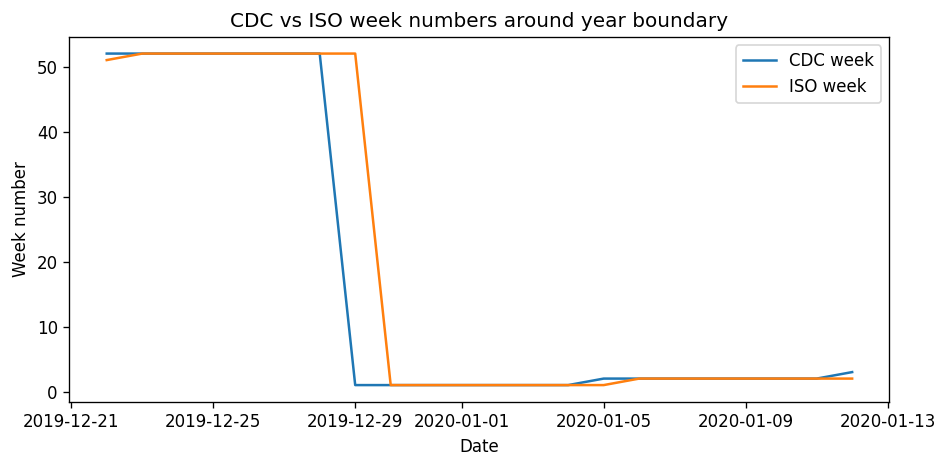

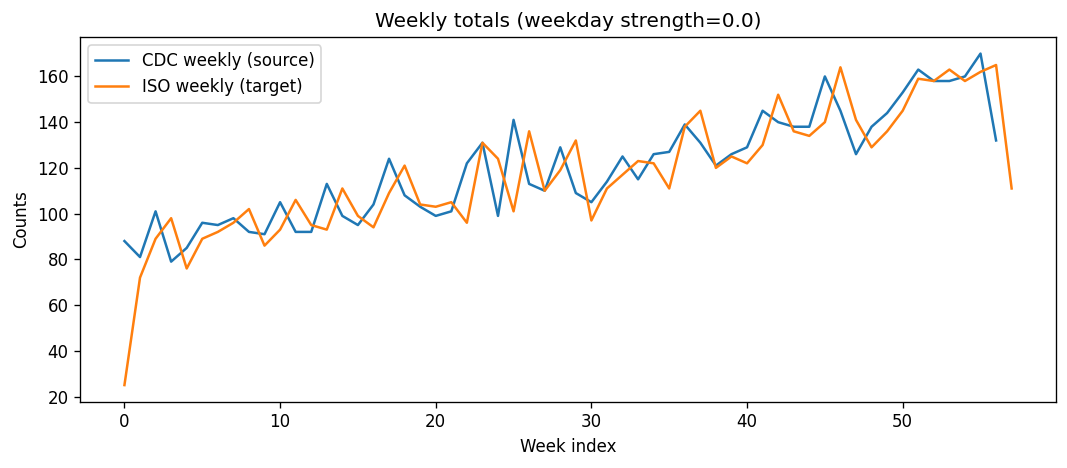

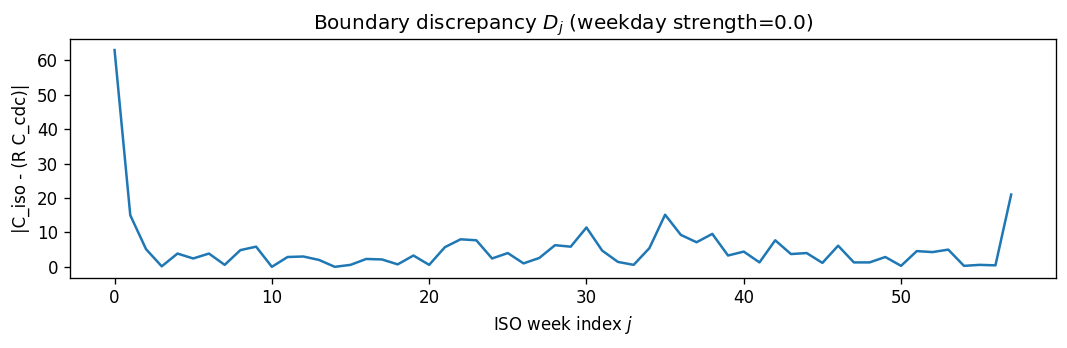

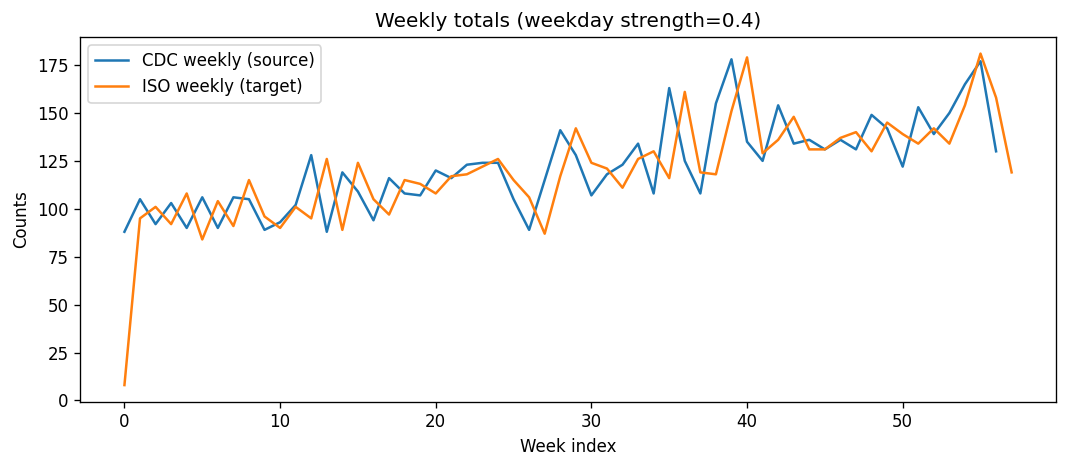

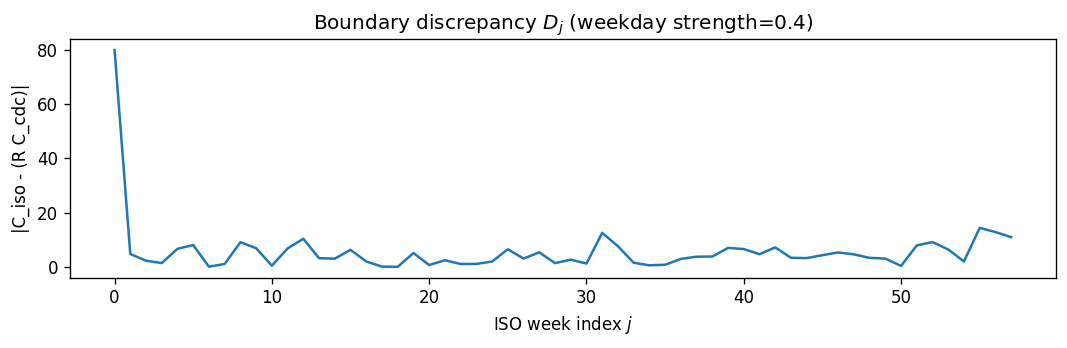

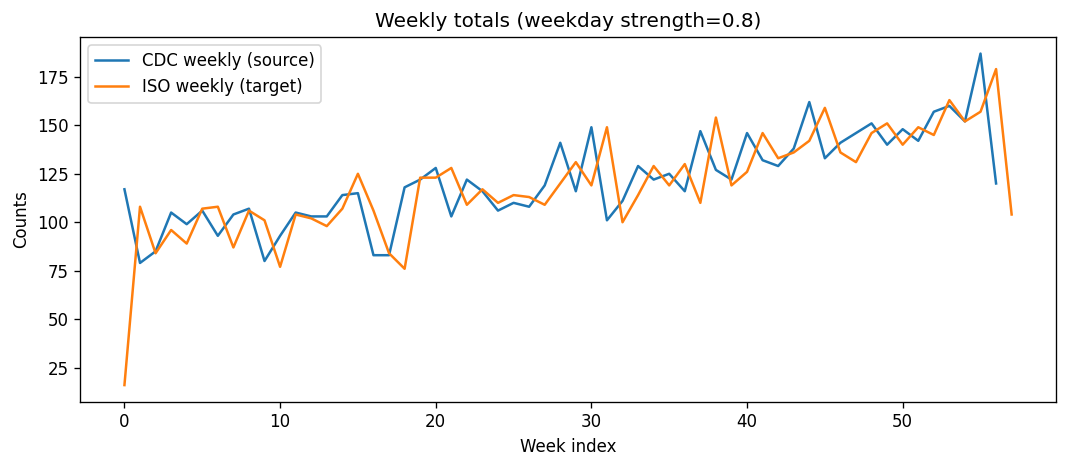

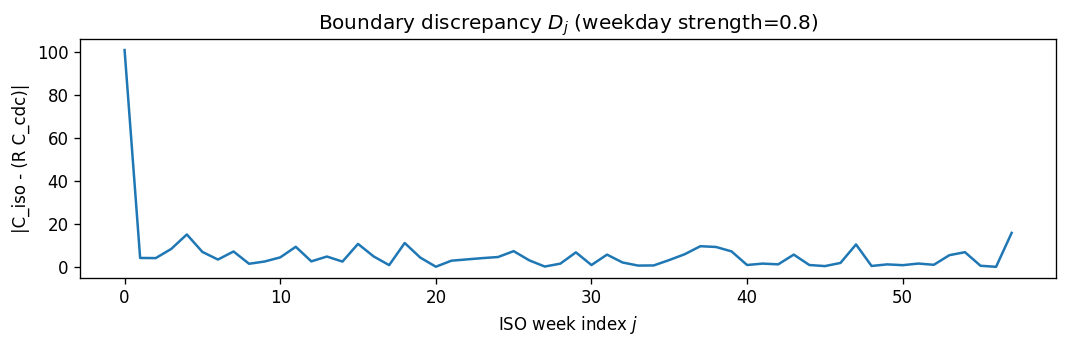


=== Simulation Summary (by weekday_strength) ===
 weekday_strength  reps  bias_naive_mean  bias_corr_mean  mae_naive  mae_corr  cover_naive  cover_corr  se_naive_mean  se_corr_mean
              0.0    40         1.240499        0.000628   1.240499  0.000830          0.0       0.825   6.821322e-12      0.000729
              0.4    40         1.228416        0.000534   1.228416  0.000662          0.0       0.900   6.690142e-12      0.000730
              0.8    40         1.255958        0.000753   1.255958  0.000782          0.0       0.850   2.922881e-12      0.000729

=== Head of Raw Results ===
 weekday_strength  rep  beta1_true  beta1_naive     se_naive  bias_naive  cover_naive  beta1_corr  se_corr  bias_corr  cover_corr  iters_naive  iters_corr
              0.0    0        0.01     1.359839 7.309031e-13    1.349839            0    0.011645 0.000733   0.001645           0          100         155
              0.0    1        0.01     1.319696 3.880292e-13    1.309696           

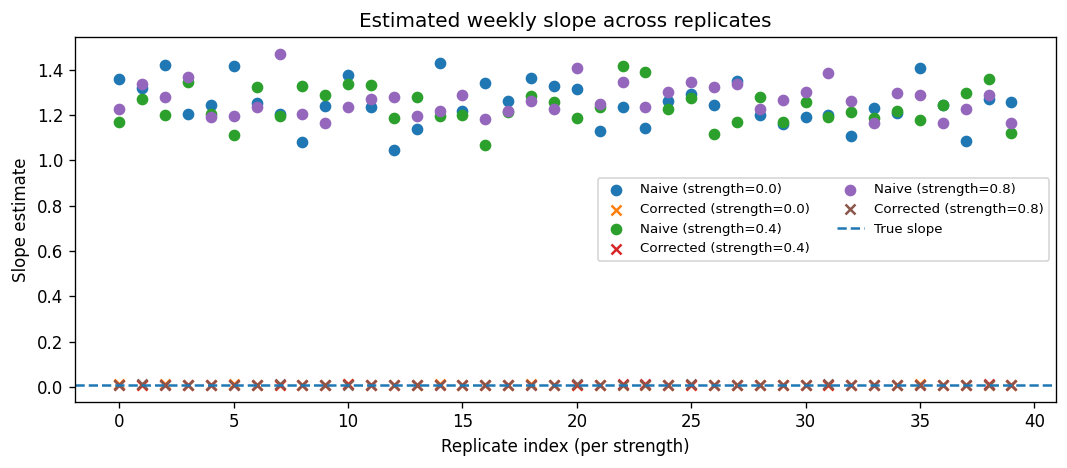


All outputs saved in: epi_sim_outputs
ZIP archive ready: epi_sim_outputs.zip


In [1]:
# run_epiweeks_sim.py
# ------------------------------------------------------------
# Simulation Study for epi-week harmonization (CDC vs ISO)
# ------------------------------------------------------------
# What you get:
# - Figures: weekly series, boundary discrepancy, slope estimates
# - Tables: per-replicate results + summary (CSV), console printouts, LaTeX tables
# - Everything saved under ./epi_sim_outputs and zipped
#
# Dependencies: numpy, pandas, matplotlib (no seaborn).
# ------------------------------------------------------------

import os, zipfile, math
from dataclasses import dataclass
from datetime import date, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ CONFIG ------------------
OUTDIR = "epi_sim_outputs"       # output folder created automatically
N_REPS = 40                      # replicates per weekday strength
WEEKDAY_STRENGTHS = (0.0, 0.4, 0.8)  # 0=uniform, larger=stronger weekday effect
SIM_START = date(2019, 12, 15)   # span includes year boundary to exercise misalignment
SIM_END   = date(2021, 1, 15)

# True weekly (CDC) log-mean: log(mu_k) = beta0 + beta1 * k
BETA0 = 4.5
BETA1_TRUE = 0.01

SEED0 = 2025  # base seed; replicate seeds derived from this

# Matplotlib – do not set specific colors or styles; one plot per figure
plt.rcParams.update({"figure.dpi": 120})

os.makedirs(OUTDIR, exist_ok=True)

# ------------------ CDC vs ISO helpers ------------------
def sunday_of_week(dt: date) -> date:
    """Return the Sunday of the week containing dt (Sunday=week start)."""
    # Python weekday(): Monday=0..Sunday=6 -> days since Sunday = (weekday+1) % 7
    return dt - timedelta(days=(dt.weekday() + 1) % 7)

def cdc_week_year(dt: date):
    """
    CDC (MMWR) week-year and week-number.
    Rule: week starts Sunday; Week 1 is the week with ≥4 days in the new year.
    Implementation via 'Thursday-in-year' rule adapted to Sunday-start.
    """
    week_start = sunday_of_week(dt)
    thursday = week_start + timedelta(days=4)
    c_year = thursday.year
    jan4 = date(c_year, 1, 4)
    first_week_start = sunday_of_week(jan4)
    if week_start < first_week_start:
        c_year -= 1
        jan4 = date(c_year, 1, 4)
        first_week_start = sunday_of_week(jan4)
    c_week = ((week_start - first_week_start).days // 7) + 1
    return c_year, c_week

def iso_week_year(dt: date):
    """ISO week-year, week-number (built-in)."""
    iso = dt.isocalendar()
    return iso.year, iso.week

def build_calendar(start: date, end: date) -> pd.DataFrame:
    """Daily calendar with CDC/ISO week labels + scheme-specific weekday indices."""
    days = (end - start).days + 1
    rows = []
    for i in range(days):
        d = start + timedelta(days=i)
        c_year, c_week = cdc_week_year(d)
        i_year, i_week = iso_week_year(d)
        cdc_wday = (d.weekday() + 1) % 7        # Sun=0,...,Sat=6
        iso_wday = d.isocalendar().weekday - 1  # Mon=0,...,Sun=6
        rows.append((d, c_year, c_week, cdc_wday, i_year, i_week, iso_wday))
    return pd.DataFrame(rows, columns=[
        "date","cdc_year","cdc_week","cdc_wday","iso_year","iso_week","iso_wday"
    ])

# ------------------ Rebinning matrix R (CDC→ISO) ------------------
def build_R_cdc_to_iso(cal_df: pd.DataFrame, p_cdc: np.ndarray):
    """
    R[j,k] = sum_{days in overlap(cdc week k, iso week j)} p_cdc[cdc_wday]
    Row-normalized per ISO week (row-stochastic). Assumes sum(p_cdc)=1.
    """
    cdc_idx = cal_df[["cdc_year","cdc_week"]].drop_duplicates().reset_index(drop=True)
    iso_idx = cal_df[["iso_year","iso_week"]].drop_duplicates().reset_index(drop=True)
    cdc_idx["k"] = np.arange(len(cdc_idx))
    iso_idx["j"] = np.arange(len(iso_idx))
    df = cal_df.merge(cdc_idx, on=["cdc_year","cdc_week"], how="left") \
               .merge(iso_idx, on=["iso_year","iso_week"], how="left")
    df["w"] = df["cdc_wday"].map(dict(enumerate(p_cdc)))
    grp = df.groupby(["j","k"], as_index=False)["w"].sum()
    R = np.zeros((len(iso_idx), len(cdc_idx)), dtype=float)
    for _, row in grp.iterrows():
        R[int(row["j"]), int(row["k"])] = float(row["w"])
    # tidy row sums
    row_sums = R.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    R = R / row_sums
    return R, iso_idx, cdc_idx

# ------------------ Simulation ------------------
@dataclass
class SimConfig:
    beta0: float = BETA0
    beta1: float = BETA1_TRUE
    weekday_strength: float = 0.0
    seed: int = 123

def weekday_profile_cdc(strength: float) -> np.ndarray:
    """
    p over CDC weekdays (Sun..Sat). Interpolate between uniform and a stylized pattern.
    """
    base = np.array([0.7, 1.0, 1.1, 1.2, 1.1, 0.9, 0.6], dtype=float)  # Sun..Sat
    base = base / base.sum()
    alpha = 1 - math.exp(-strength)  # smooth 0→1 as strength grows
    uniform = np.ones(7) / 7.0
    p = (1 - alpha) * uniform + alpha * base
    return p / p.sum()

def simulate_one(cal_df: pd.DataFrame, cfg: SimConfig):
    """
    Generate daily counts:
      1) Weekly latent mu_k in CDC space: exp(beta0 + beta1*k)
      2) Split mu_k into days via p_cdc (weekday profile)
      3) Y_t ~ Poisson(lambda_t)
    Return daily frame + weekly CDC/ISO totals + R (CDC→ISO).
    """
    rng = np.random.default_rng(cfg.seed)
    p_cdc = weekday_profile_cdc(cfg.weekday_strength)

    cdc_idx = cal_df[["cdc_year","cdc_week"]].drop_duplicates().reset_index(drop=True)
    iso_idx = cal_df[["iso_year","iso_week"]].drop_duplicates().reset_index(drop=True)
    cdc_idx["k"] = np.arange(len(cdc_idx))
    iso_idx["j"] = np.arange(len(iso_idx))

    df = cal_df.merge(cdc_idx, on=["cdc_year","cdc_week"], how="left") \
               .merge(iso_idx, on=["iso_year","iso_week"], how="left")

    k_unique = cdc_idx["k"].values
    mu_week = np.exp(cfg.beta0 + cfg.beta1 * k_unique)  # CDC weekly means

    # Allocate to days via CDC weekday index
    lam = np.exp(cfg.beta0 + cfg.beta1 * df["k"].values) * np.array([p_cdc[d] for d in df["cdc_wday"].values])
    Y = rng.poisson(lam)

    sim_df = df.copy()
    sim_df["mu_daily"] = lam
    sim_df["Y"] = Y

    cdc_weekly = sim_df.groupby(["cdc_year","cdc_week","k"], as_index=False)["Y"].sum().rename(columns={"Y":"C_cdc"})
    iso_weekly = sim_df.groupby(["iso_year","iso_week","j"], as_index=False)["Y"].sum().rename(columns={"Y":"C_iso"})

    R_true, iso_index, cdc_index = build_R_cdc_to_iso(cal_df, p_cdc)

    return {
        "sim_df": sim_df,
        "cdc_weekly": cdc_weekly,
        "iso_weekly": iso_weekly,
        "R_true": R_true,
        "p_cdc": p_cdc,
        "iso_index": iso_index,
        "cdc_index": cdc_index,
        "mu_week": mu_week
    }

# ------------------ Poisson GLMs ------------------
def fit_poisson_glm_counts(y: np.ndarray, X: np.ndarray, maxit=100, tol=1e-8):
    """
    Poisson GLM with log link: y ~ Poisson(exp(X beta)).
    Newton-Raphson using expected Fisher. Returns beta, se, iters.
    """
    n, p = X.shape
    beta = np.zeros(p)
    for it in range(maxit):
        eta = X @ beta
        mu = np.exp(eta)
        g = X.T @ (y - mu)
        W = mu
        H = (X.T * W) @ X
        try:
            step = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            step = np.linalg.lstsq(H + 1e-8*np.eye(p), g, rcond=None)[0]
        beta_new = beta + step
        if np.linalg.norm(step) < tol:
            beta = beta_new
            break
        beta = beta_new
    # SEs
    eta = X @ beta
    mu = np.exp(eta)
    W = mu
    H = (X.T * W) @ X
    try:
        cov = np.linalg.inv(H)
    except np.linalg.LinAlgError:
        cov = np.linalg.pinv(H)
    se = np.sqrt(np.diag(cov))
    return beta, se, it+1

def fit_misaligned_poisson(y_iso: np.ndarray, R: np.ndarray, K: int, maxit=200, tol=1e-8):
    """
    Misaligned likelihood:
      y_iso_j ~ Pois( sum_k R_jk * mu_k ),  mu_k = exp(beta0 + beta1*k)
    """
    k_vec = np.arange(K).astype(float)
    Xs = np.vstack([np.ones(K), k_vec]).T  # K x 2
    beta = np.zeros(2)
    for it in range(maxit):
        eta_k = Xs @ beta
        mu_k = np.exp(eta_k)             # K
        nu = R @ mu_k                    # J
        # Gradient g = sum_j (y_j/nu_j - 1) * (sum_k R_jk mu_k X_k)
        A = (mu_k[:, None] * Xs)         # K x 2
        factor = (y_iso / np.maximum(nu, 1e-12) - 1.0)  # J
        b = R.T @ factor                 # K
        g = (A * b[:, None]).sum(axis=0) # 2,
        # Fisher I = sum_j (1/nu_j) * v_j v_j^T where v_j = sum_k R_jk mu_k X_k
        RA = R @ A                       # J x 2
        I = np.zeros((2,2))
        for j in range(RA.shape[0]):
            v = RA[j, :]
            I += np.outer(v, v) / max(nu[j], 1e-12)
        try:
            step = np.linalg.solve(I, g)
        except np.linalg.LinAlgError:
            step = np.linalg.lstsq(I + 1e-8*np.eye(2), g, rcond=None)[0]
        beta_new = beta + step
        if np.linalg.norm(step) < tol:
            beta = beta_new
            break
        beta = beta_new
    try:
        cov = np.linalg.inv(I)
    except np.linalg.LinAlgError:
        cov = np.linalg.pinv(I)
    se = np.sqrt(np.diag(cov))
    return beta, se, it+1

# ------------------ Experiment runner ------------------
def run_experiment():
    cal_df = build_calendar(SIM_START, SIM_END)

    # Figure: CDC vs ISO week numbers near boundary (for paper)
    short = cal_df[(cal_df["date"]>=date(2019,12,22)) & (cal_df["date"]<=date(2020,1,12))].copy()
    fig = plt.figure(figsize=(8,4))
    plt.plot(short["date"], short["cdc_week"], label="CDC week")
    plt.plot(short["date"], short["iso_week"], label="ISO week")
    plt.title("CDC vs ISO week numbers around year boundary")
    plt.xlabel("Date"); plt.ylabel("Week number")
    plt.legend()
    fpath = os.path.join(OUTDIR, "fig_week_numbers.png")
    plt.tight_layout(); plt.savefig(fpath); plt.show()

    results = []
    example_tables = {}

    for strength in WEEKDAY_STRENGTHS:
        for rep in range(N_REPS):
            seed = SEED0 + 1000*int(100*strength) + rep
            sim = simulate_one(cal_df, SimConfig(BETA0, BETA1_TRUE, strength, seed))
            R = sim["R_true"]
            C_cdc = sim["cdc_weekly"].sort_values("k")["C_cdc"].to_numpy()
            iso_sorted = sim["iso_weekly"].sort_values("j")
            C_iso = iso_sorted["C_iso"].to_numpy()

            K = len(C_cdc)
            J = len(C_iso)
            X_iso = np.vstack([np.ones(J), np.arange(J)]).T

            # Naive fit (ignores misalignment, treats ISO weeks as the model weeks)
            b_naive, se_naive, it_n = fit_poisson_glm_counts(C_iso, X_iso)
            # Corrected fit (uses R to estimate CDC trend from ISO observations)
            b_corr, se_corr, it_c = fit_misaligned_poisson(C_iso, R, K)

            bias_naive = b_naive[1] - BETA1_TRUE
            bias_corr = b_corr[1] - BETA1_TRUE
            cover_naive = int(BETA1_TRUE >= b_naive[1]-1.96*se_naive[1] and BETA1_TRUE <= b_naive[1]+1.96*se_naive[1])
            cover_corr  = int(BETA1_TRUE >= b_corr[1]-1.96*se_corr[1]  and BETA1_TRUE <= b_corr[1]+1.96*se_corr[1])

            results.append({
                "weekday_strength": strength, "rep": rep,
                "beta1_true": BETA1_TRUE,
                "beta1_naive": b_naive[1], "se_naive": se_naive[1], "bias_naive": bias_naive, "cover_naive": cover_naive,
                "beta1_corr":  b_corr[1],  "se_corr":  se_corr[1],  "bias_corr":  bias_corr,  "cover_corr":  cover_corr,
                "iters_naive": it_n, "iters_corr": it_c
            })

            # Save illustrative plots/tables for first replicate of each strength
            if rep == 0:
                # Weekly CDC vs ISO series
                fig = plt.figure(figsize=(9,4))
                plt.plot(np.arange(len(C_cdc)), C_cdc, label="CDC weekly (source)")
                plt.plot(np.arange(len(C_iso)), C_iso, label="ISO weekly (target)")
                plt.title(f"Weekly totals (weekday strength={strength})")
                plt.xlabel("Week index"); plt.ylabel("Counts")
                plt.legend()
                fpath = os.path.join(OUTDIR, f"fig_weekly_cdc_iso_strength{strength}.png")
                plt.tight_layout(); plt.savefig(fpath); plt.show()

                # Boundary discrepancy D_j
                D = np.abs(C_iso - (R @ C_cdc))
                fig = plt.figure(figsize=(9,3))
                plt.plot(D)
                plt.title(f"Boundary discrepancy $D_j$ (weekday strength={strength})")
                plt.xlabel("ISO week index $j$"); plt.ylabel("|C_iso - (R C_cdc)|")
                fpath = os.path.join(OUTDIR, f"fig_boundary_discrepancy_strength{strength}.png")
                plt.tight_layout(); plt.savefig(fpath); plt.show()

                ex = iso_sorted.copy()
                ex["C_iso_from_cdc"] = (R @ C_cdc)
                ex["D"] = D
                example_tables[f"iso_table_strength{strength}"] = ex.head(12)

    res_df = pd.DataFrame(results)
    summary = res_df.groupby("weekday_strength").agg(
        reps=("rep","count"),
        bias_naive_mean=("bias_naive","mean"),
        bias_corr_mean=("bias_corr","mean"),
        mae_naive=("bias_naive", lambda x: np.mean(np.abs(x))),
        mae_corr=("bias_corr", lambda x: np.mean(np.abs(x))),
        cover_naive=("cover_naive","mean"),
        cover_corr=("cover_corr","mean"),
        se_naive_mean=("se_naive","mean"),
        se_corr_mean=("se_corr","mean"),
    ).reset_index()

    # Save CSVs
    res_csv = os.path.join(OUTDIR, "simulation_results_raw.csv")
    sum_csv = os.path.join(OUTDIR, "simulation_summary.csv")
    res_df.to_csv(res_csv, index=False)
    summary.to_csv(sum_csv, index=False)

    # Print console tables (easy copy-paste)
    print("\n=== Simulation Summary (by weekday_strength) ===")
    print(summary.to_string(index=False))

    print("\n=== Head of Raw Results ===")
    print(res_df.head(10).to_string(index=False))

    # Optional: also print LaTeX tables for your paper
    try:
        print("\n=== LaTeX table: Simulation Summary ===")
        print(summary.to_latex(index=False, float_format="%.4f"))
    except Exception as e:
        pass

    # Figure: slope estimates across replicates (naive vs corrected)
    fig = plt.figure(figsize=(9,4))
    for s in WEEKDAY_STRENGTHS:
        sub = res_df[res_df["weekday_strength"]==s].reset_index(drop=True)
        x = np.arange(len(sub))
        plt.scatter(x, sub["beta1_naive"], label=f"Naive (strength={s})", marker="o")
        plt.scatter(x, sub["beta1_corr"],  label=f"Corrected (strength={s})", marker="x")
    plt.axhline(BETA1_TRUE, linestyle="--", label="True slope")
    plt.title("Estimated weekly slope across replicates")
    plt.xlabel("Replicate index (per strength)"); plt.ylabel("Slope estimate")
    plt.legend(ncol=2, fontsize=8)
    fpath = os.path.join(OUTDIR, "fig_beta1_estimates.png")
    plt.tight_layout(); plt.savefig(fpath); plt.show()

    # Save example tables
    for name, df in example_tables.items():
        df.to_csv(os.path.join(OUTDIR, f"{name}.csv"), index=False)

    # Zip everything
    zip_path = "epi_sim_outputs.zip"
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
        for root, _, files in os.walk(OUTDIR):
            for fn in files:
                fp = os.path.join(root, fn)
                zf.write(fp, arcname=os.path.relpath(fp, OUTDIR))

    print(f"\nAll outputs saved in: {OUTDIR}")
    print(f"ZIP archive ready: {zip_path}")

if __name__ == "__main__":
    run_experiment()
